In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#stylo data
link = 'https://drive.google.com/open?id=1qg3fx5JyibrfBBycl3y8hCQJWBiXkP2N'

fluff, id = link.split('=')
print(id)
filename = 'stylo-data-3.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(filename)

# data without stopwords
raw_data_link = 'https://drive.google.com/open?id=1QKJm85j3xeOz4iIgd5D82i7tc3vg0zMW'

#raw data text
#raw_data_link = 'https://drive.google.com/open?id=1DZkGVcBNQ1WUk11dVRzJcbGNeAb8rOaJ'

fluff, id = raw_data_link.split('=')
print(id)
raw_filename = 'raw_data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(raw_filename)

#news stylo dataset
news_link = 'https://drive.google.com/open?id=1C5MS8fWH2yS5GKS_TVddhuXPgR63JC-c'
fluff, id = news_link.split('=')
print(id)
news_filename = 'news-data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(news_filename)


1qg3fx5JyibrfBBycl3y8hCQJWBiXkP2N
1QKJm85j3xeOz4iIgd5D82i7tc3vg0zMW
1C5MS8fWH2yS5GKS_TVddhuXPgR63JC-c


In [2]:
# Download gloVe word embedding for portuguese-BR (100-dimensions)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

glove_50_link = 'https://drive.google.com/open?id=10MW2F53DYYxizSXLbvfsphs77Fu1U9Gz'

fluff, id = glove_50_link.split('=')
print(id)
glove_file_name = 'glove_s50.txt'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(glove_file_name)
glove_file_name

10MW2F53DYYxizSXLbvfsphs77Fu1U9Gz


'glove_s50.txt'

In [3]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

!pip install scikit-fuzzy
import skfuzzy as fuzz
from sklearn.cluster import MiniBatchKMeans

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, Normalizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.cluster import KMeansClusterer
from sklearn import cluster, metrics
nltk.download('punkt')
nltk.download('stopwords')

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

     |████████████████████████████████| 1.0MB 2.8MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894070 sha256=8dee3d350ee43e9630f9ab0a25aa02f64e6623b2d3ef4552d921b923cedc93fa
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [0]:
# read dataset
df = pd.read_csv(filename)
raw_df = pd.read_csv(raw_filename)
news_df = pd.read_csv(news_filename)

# Remove single class entries (We need at least 3 samples of an author
df = df.groupby('Author').filter(lambda x: len(x) > 3)
y = df.pop('Author')
raw_df = raw_df.groupby('Author').filter(lambda x: len(x) > 3)

le = LabelEncoder()
le.fit(y)
encoded_Y = le.transform(y)


le = LabelEncoder()
y_news = news_df.pop('Author')
le.fit(y_news)
encoded_Y_news = le.transform(y_news)

le.fit(raw_df['Author'])
encoded_raw_Y = le.transform(raw_df['Author'])
raw_df['Author'] = encoded_raw_Y


In [0]:
# Load the embedding into a dictionary (eg: {'oi' : n1, n2, ..., n100})
word_embedding_dict = {}
with open(glove_file_name, 'r', encoding='utf-8') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)  
    coefs = np.fromstring(coefs, 'f', sep=' ')
    word_embedding_dict[word] = coefs

In [0]:
#word_embedding_dict.keys()

In [7]:
corpus = raw_df['Text']

# Create a Keras tokenizer and convert words to integer values
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(corpus)

# Convert strings to their corresponding integer value created by the Tokenizer
embedded_sentences = tokenizer.texts_to_sequences(corpus)
#print(embedded_sentences)

max_words_text = max(corpus, key=lambda sentence: len(nltk.word_tokenize(sentence, language='portuguese')))
#print(max_words_text)

max_sentence_len = len(nltk.word_tokenize(max_words_text, language='portuguese'))
print(max_sentence_len)

padded_sentences = pad_sequences(embedded_sentences, max_sentence_len, padding='post')

print(padded_sentences.shape)
vocab_len = len(tokenizer.word_index) + 1

# Create an embedding matrix, in other words, use the weights from gloVe vector against all our corpus
# In the end we will have a matrix of all our vocabulary x 50 dimensions (size of glove dim)

# initialize with all zeros
embedding_matrix = np.zeros((vocab_len, 50))
for word, index in tokenizer.word_index.items():
  embedding_vector = word_embedding_dict.get(word)
  # if the word is in gloVe, we will use its weigths 
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector[:50]

#embedding_matrix


3913
(69, 3913)


In [0]:
#tokenizer.word_index.items()

In [0]:
def build_weighted_document(padded_sentences):
  weigthed_documents = []
  for text in padded_sentences:
    document = np.zeros((vocab_len))
    embedding_vector = word_embedding_dict.get(text)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector[:50]
    weigthed_documents.append(document)

In [10]:
padded_sentences.shape

(69, 3913)

In [0]:
#Some clean-up on textual contents

raw_df = raw_df.replace(to_replace ='\r', value = ' ', regex = True) 
raw_df = raw_df.replace(to_replace ='\n ', value = '\n', regex = True) 
raw_df = raw_df.replace(to_replace ='\n{2,*}', value = ' ', regex = True) 

In [12]:
tagged_documents = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(raw_df['Text'])]

print (tagged_documents)

model = Doc2Vec(tagged_documents, vector_size=30, min_count=1, workers=4)

documents = [doc.words for doc in tagged_documents]
#print(documents)

[TaggedDocument(words=['respostas', 'ecologia', 'evolutiva', 'retirar', 'amostra', 'planta', 'mata', 'replanta-la', 'recipiente', 'solo', 'carente', 'água.', 'outro', 'ambiente,', 'desde', 'poucos', 'recurso', 'hídricos.', 'plantas', 'mesma', 'espécie,', 'possivelmente', 'raízes', 'tenderiam', 'crescer', 'busca', 'água', 'nutrientes.', 'caso', 'haver', 'plasticidade', 'fenotípica;', 'poderia', 'ser', 'ter', 'ocorrido', 'efeito', 'gargalo', 'garrafa,', 'alelos', 'possibilitaram', 'plasticidade', 'perdidos', 'seleção', 'natural;', 'poderia', 'ter', 'ocorrido', 'outro', 'processo,', 'efeito', 'fundador,', 'após', 'seleção', 'sobrou', 'poucos', 'indivíduos', 'possuiriam', 'alelos', 'usar', 'estratégia.', 'caso', 'todas', 'possuírem', 'estratégia,', 'poderia', 'ser', 'fato', 'ambiente', 'passava', 'períodos', 'seca', 'somente', 'informação', 'genética', 'conseguiam', 'sobreviver', 'reproduzir,', 'propagando', 'alelos', 'próximas', 'gerações', '(seleção', 'natural).', 'plantas', 'possuíssem'

In [0]:
# Create a wordcloud for each one of the authors

stopwords = set(nltk.corpus.stopwords.words('portuguese'))

def get_words(text):
  words = ' '.join(text)
  tokens = nltk.word_tokenize(words, language = 'portuguese')
  embedded_tokens = [token for token in tokens if token.lower() in word_embedding_dict.keys()]
  return " ".join(embedded_tokens)

def build_wordcloud(words, stopwords):
  return WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=500,
                      height=500
                     ).generate(get_words(words))

wcs = []
for i in range(0,11):
  wcs.append(build_wordcloud(raw_df.loc[raw_df['Author'] == i]['Text'], stopwords))

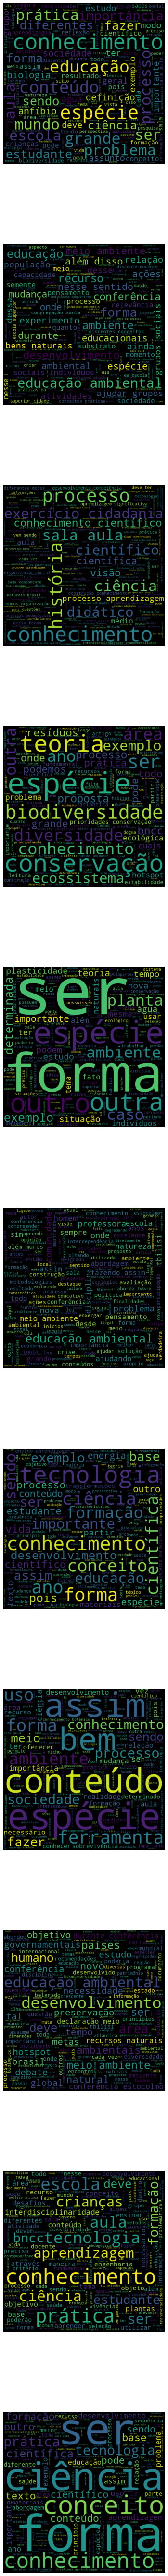

In [14]:
# Display Wordclouds
fig = plt.figure()
fig.set_figheight(100)
for idx, i  in enumerate(wcs):
    ax = fig.add_subplot(len(wcs),1,idx+1)
    wordcloud = i
    ax.imshow(wordcloud)
    ax.axis('off')

In [15]:
# Amount of works and valid tokens 

authors = {}
for i in range(0,11):
  author_texts = raw_df.loc[raw_df['Author'] == i]['Text']
  words = get_words(author_texts)
  tokens = nltk.word_tokenize(words, language = 'portuguese')
  tokens = [w for w in tokens if w.lower() not in stopwords]
  authors[le.inverse_transform([i])[0]] = (len(author_texts), len(tokens)) 

authors


{'bmm': (10, 3204),
 'fadj': (6, 3090),
 'flg': (4, 5609),
 'mj': (5, 2124),
 'pdje': (5, 1200),
 'sdcm': (4, 736),
 'sdeg': (8, 2753),
 'sdfi': (9, 2059),
 'sdjme': (7, 941),
 'sdlmm': (4, 1442),
 've': (7, 2435)}

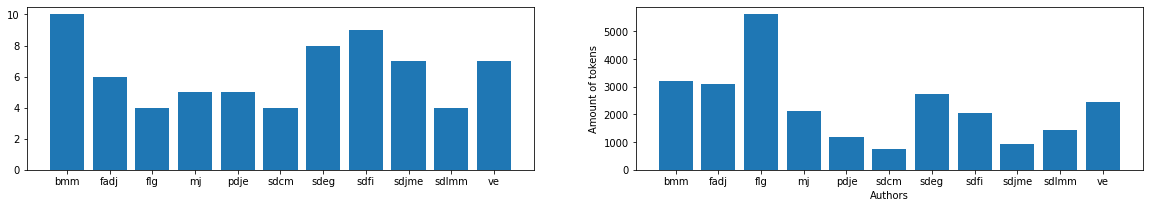

In [16]:
#Plot author works and the number of valid tokens

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))

word_count = [size[1] for size in authors.values()]
X = authors.keys()
works_count =  [size[0] for size in authors.values()]
axes[0].bar(X,works_count)

plt.ylabel('Amount of tokens')
plt.xlabel('Authors')



axes[1].bar(X,word_count)
plt.show()


In [0]:
# Scale our stylometric datasets

scaled_features_news = PowerTransformer().fit_transform(news_df.values)
news_df = pd.DataFrame(scaled_features_news, index=news_df.index, columns=news_df.columns)

scaled_features = PowerTransformer().fit_transform(df.values)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [0]:
# Feature reduction PCA d=3 and Scaled features

def build_components(dataframe, size):
  pca = PCA(n_components=size)
  pca_result = pca.fit_transform(dataframe.values)
  dataframe['PCA-one'] = pca_result[:,0]
  dataframe['PCA-two'] = pca_result[:,1] 
  dataframe['PCA-three'] = pca_result[:,2]
  return pca

pca_news = build_components(news_df, 3)
pca_stylo = build_components(df, 3)

In [0]:
# le = LabelEncoder()
# le.fit(y)
# encoded_Y = le.transform(y)

news_df['Author'] = encoded_Y_news

df['Author'] = encoded_Y

<Figure size 432x288 with 0 Axes>

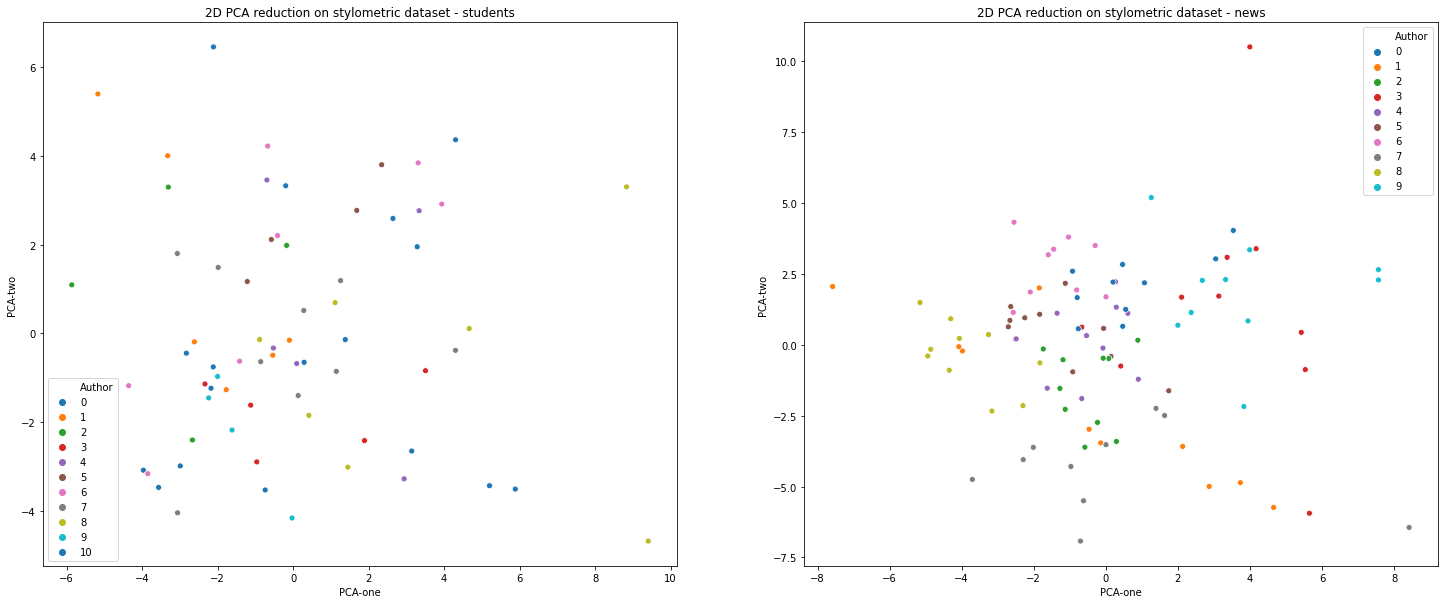

<Figure size 432x288 with 0 Axes>

In [20]:
# Plot stylometric data on PCA-2D and Scaled features

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(25, 10)

sns.scatterplot(
    x="PCA-one", y="PCA-two",
    hue="Author",
    palette=sns.color_palette("tab10", 11),
    data=df,
    legend="full",
    ax=ax1
)

sns.scatterplot(
    x="PCA-one", y="PCA-two",
    hue="Author",
    palette=sns.color_palette("tab10", 10),
    data=news_df,
    legend="full",
    ax=ax2
)

ax1.set_title('2D PCA reduction on stylometric dataset - students')
ax2.set_title('2D PCA reduction on stylometric dataset - news')
plt.figure()


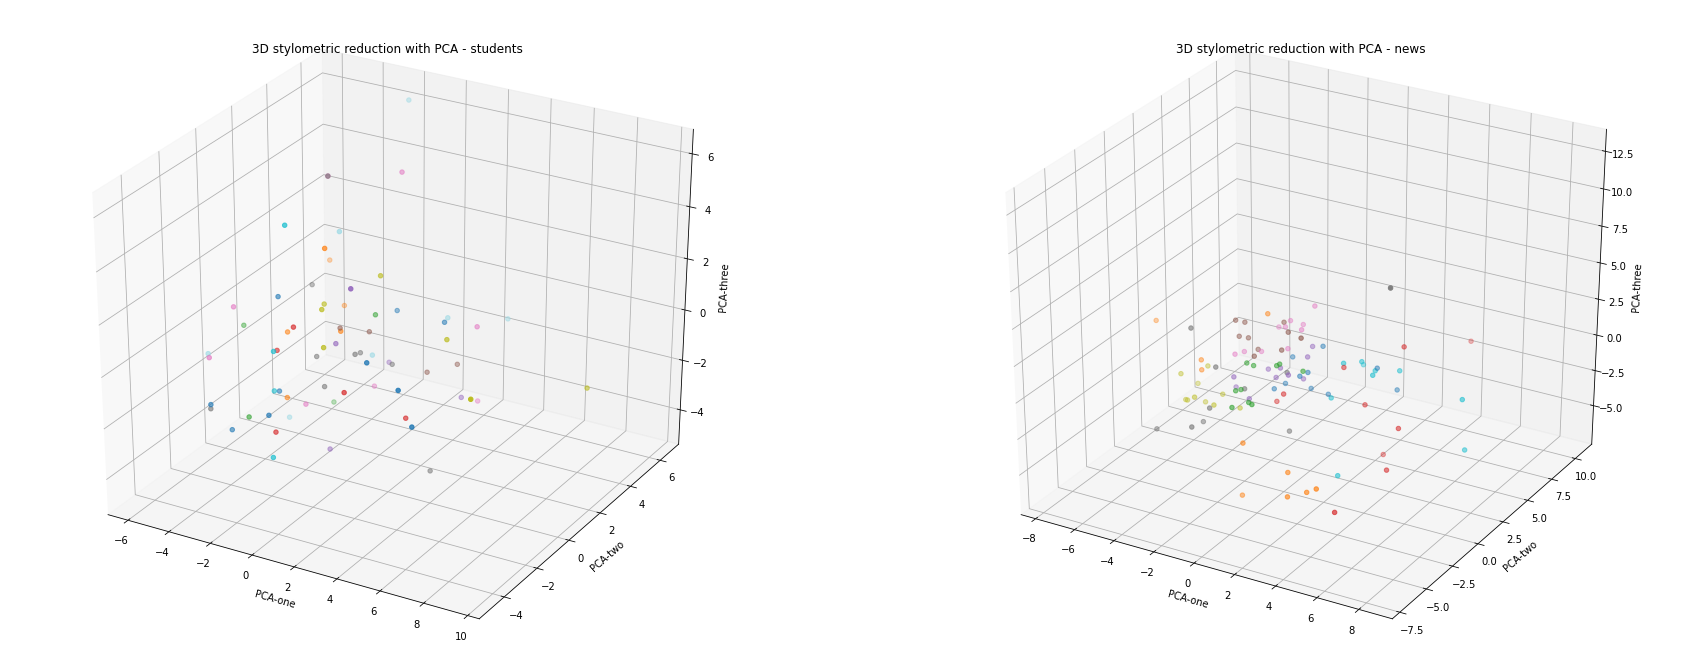

In [21]:
# Plot stylometric data on PCA-3D and Scaled features
fig = plt.figure(figsize=(30,12))

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(
    xs=df.loc[:]["PCA-one"], 
    ys=df.loc[:]["PCA-two"], 
    zs=df.loc[:]["PCA-three"], 
    c=df.loc[:]["Author"], 
    cmap='tab20',
)
ax.set_xlabel('PCA-one')
ax.set_ylabel('PCA-two')
ax.set_zlabel('PCA-three')
ax.set_title('3D stylometric reduction with PCA - students')

ax1 = fig.add_subplot(1, 2, 2, projection='3d')


ax1.scatter(
    xs=news_df.loc[:]["PCA-one"], 
    ys=news_df.loc[:]["PCA-two"], 
    zs=news_df.loc[:]["PCA-three"], 
    c=news_df.loc[:]["Author"], 
    cmap='tab10'
)
ax1.set_xlabel('PCA-one')
ax1.set_ylabel('PCA-two')
ax1.set_zlabel('PCA-three')
ax1.set_title('3D stylometric reduction with PCA - news')

plt.show()

In [0]:
# Clear dfs
def clear_df(dataframes):
  for df in dataframes:
    df.pop('PCA-one')
    df.pop('PCA-two')
    df.pop('PCA-three')

clear_df([df, news_df])

In [23]:
# Train model for TNSE reduction and Scaled features

def build_tsne(dataframe, size):
  y = dataframe.pop('Author')
  tsne = TSNE(n_components=size, verbose=1, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(dataframe)
  dataframe['TSNE-2d-one'] = tsne_results[:,0]
  dataframe['TSNE-2d-two'] = tsne_results[:,1]
  dataframe['TSNE-2d-three'] = tsne_results[:,2]
  dataframe['Author'] = y


build_tsne(df, 3)
build_tsne(news_df, 3)

[t-SNE] Computing 68 nearest neighbors...
[t-SNE] Indexed 69 samples in 0.000s...
[t-SNE] Computed neighbors for 69 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 69 / 69
[t-SNE] Mean sigma: 4.735647
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.083229
[t-SNE] KL divergence after 300 iterations: 2.861713
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 3.880083
[t-SNE] KL divergence after 250 iterations with early exaggeration: 128.990936
[t-SNE] KL divergence after 300 iterations: 2.342061


<Figure size 432x288 with 0 Axes>

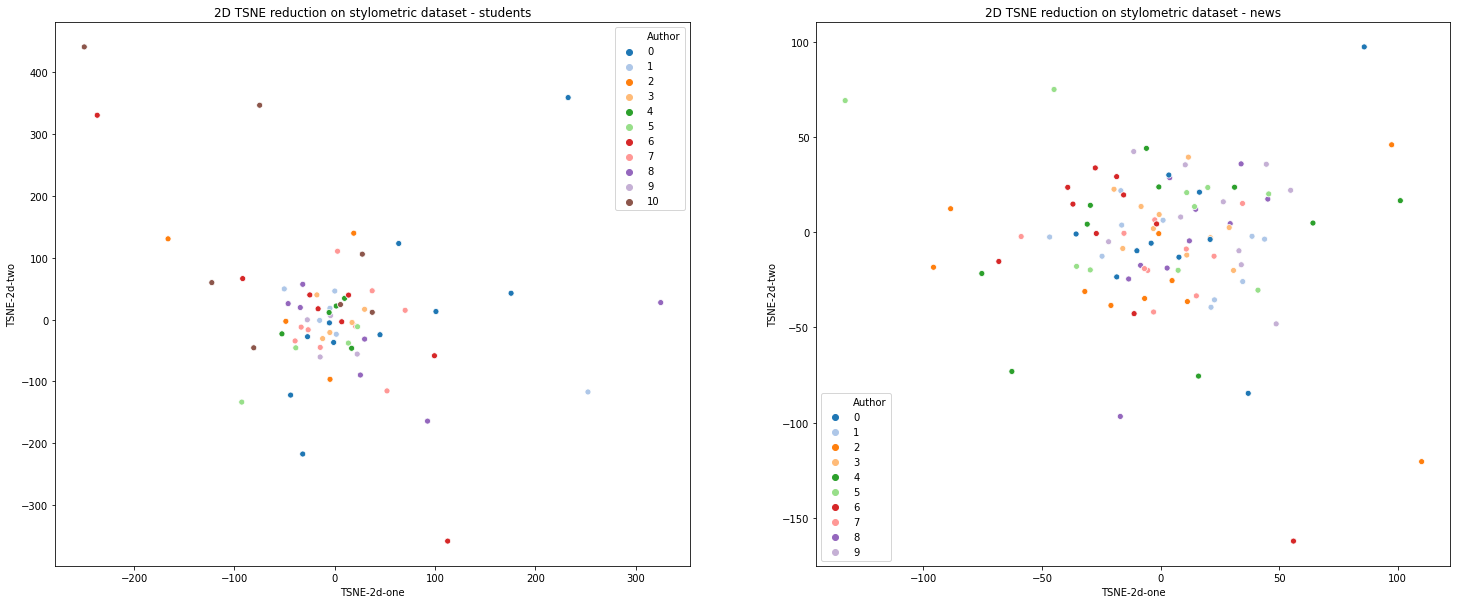

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot stylometric data on TSNE-2D and Scaled features

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(25, 10)

sns.scatterplot(
    x="TSNE-2d-one", y="TSNE-2d-two",
    hue="Author",
    palette=sns.color_palette("tab20", 11),
    data=df,
    legend="full",
    ax=ax1
)

sns.scatterplot(
    x="TSNE-2d-one", y="TSNE-2d-two",
    hue="Author",
    palette=sns.color_palette("tab20", 10),
    data=news_df,
    legend="full",
    ax=ax2
)

ax1.set_title('2D TSNE reduction on stylometric dataset - students')
ax2.set_title('2D TSNE reduction on stylometric dataset - news')
plt.figure()

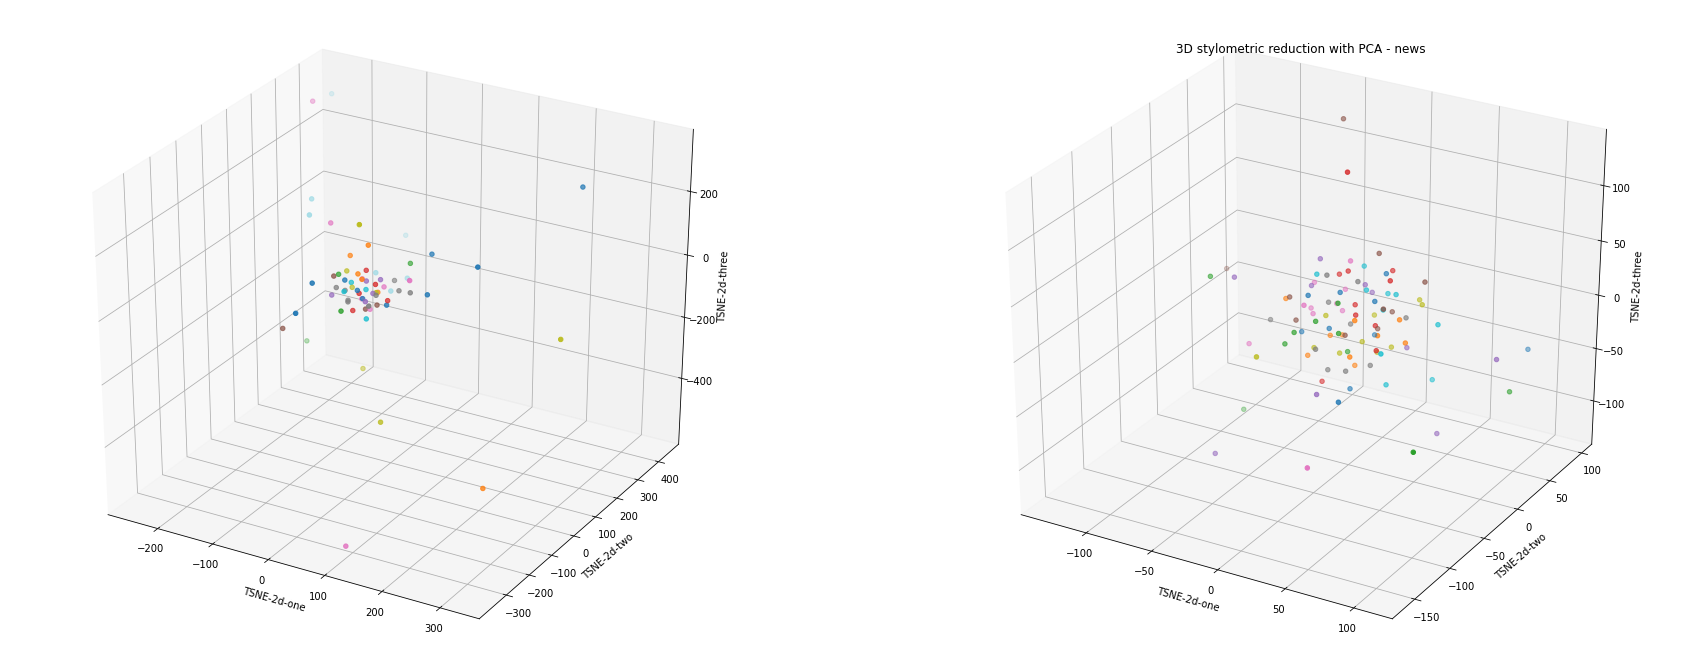

In [25]:
# Plot stylometric data on TSNE-3D and Scaled features

fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')


ax.scatter(
    xs=df.loc[:]["TSNE-2d-one"], 
    ys=df.loc[:]['TSNE-2d-two'], 
    zs=df.loc[:]['TSNE-2d-three'], 
    c=df.loc[:]["Author"], 
    cmap='tab20',
)
ax.set_xlabel('TSNE-2d-one')
ax.set_ylabel('TSNE-2d-two')
ax.set_zlabel('TSNE-2d-three')

ax1 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.scatter(
    xs=news_df.loc[:]["TSNE-2d-one"], 
    ys=news_df.loc[:]["TSNE-2d-two"], 
    zs=news_df.loc[:]["TSNE-2d-three"], 
    c=news_df.loc[:]["Author"], 
    cmap='tab10'
)
ax1.set_xlabel('TSNE-2d-one')
ax1.set_ylabel('TSNE-2d-two')
ax1.set_zlabel('TSNE-2d-three')
ax1.set_title('3D stylometric reduction with PCA - news')

plt.show()